# Compare reservoir routines
***

**Author:** *Chus Casado Rodríguez*<br>
**Date:** *15-07-2024*<br>

**Introduction:**<br>

This notebooks compares the results of simulating 97 reservoirs from the ResOpsUS. These reservoirs were selected because the include observed data for the three variables inflow, storage and outflow for at least 8 consecutive years.

Four reservoir routines were tested:

1. [**Linear reservoir**](../../src/lisfloodreservoirs/models/linear.py). In this routine the outflow is a linear function of the current storage. The only parameter is the residence time ($T$).

<img src="../../results/ResOpsUS/linear/default/1053_scatter_obs_sim.jpg" alt="reservoir 1053" title="Linear routine" width="800">


2. [**Lisflood**](../../src/lisfloodreservoirs/models/lisflood.py). The current LISFLOOD routine is a concatenation of linear reservoirs, where the constant connecting storage and outflow changes according the storage zone at which the reservoir is at that moment: conservative, normal or flood.

<img src="../../results/ResOpsUS/lisflood/default/1053_scatter_obs_sim.jpg" alt="reservoir 1053" title="Linear routine" width="800">

3. [**Hanazaki**](../../src/lisfloodreservoirs/models/hanazaki.py). The routine in [Hanazaki et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002944) is an evolution of the LISFLOOD routine that creates two different reservoir operations depending on the inflow. If the inflow is smaller than the flood outflow, the outflow is a quadratic function of the storage; this quadratic behaviour limits the outflow when the reservoir empties, hence storing more water for future needs. If the inflow is larger than the flood outflow, it's a linear reservoir.

<img src="../../results/ResOpsUS/hanazaki/default/1053_scatter_obs_sim.jpg" alt="reservoir 1053" title="Linear routine" width="800">

4. [**mHM**](../../src/lisfloodreservoirs/models/mhm.py). This routine differs from the others as outflow is not a univocal function of storage. Instead, it relies heavily on a demand time series that need to be estimated somehow. In the [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2023WR035433), they train a random forest specific to each reservoir to predict the demand. The demand time series is used to limit releases (store water) when the current demand is lower compared with the annual mean, and to increase releases (empty the reservoir) with higher demands. The final release is further constrained by the current reservoir filling.

<img src="../../results/ResOpsUS/mhm/default/1053_scatter_obs_sim.jpg" alt="reservoir 1053" title="Linear routine" width="800">

For each routine, 4 simulations were run. In all cases, the input is the observed reservoir inflow. In previous tests I had used GloFAS simulations to be able to test reservoir for which there is no observed inflow. This time I tried to avoid errors induced by the quality of the GloFAS estimated inflow.

1. A simulation with **default parameters**. To run this simulations I've created the command [`simulate`](../../src/lisfloodreservoirs/simulate.py).
2. Three calibrations:
    * Univariate calibration of **storage**.
    * Univariate calibration of **outflow**.
    * Bivariate calibration of both **storage and outflow**.
    
    Calibrations were done using the implementation of the SCEUA (Shuffle Complex Evolution - University of Arizona) algorithm in the Python library [`spotpy`](https://spotpy.readthedocs.io/en/latest/). In all cases I used the complete observed time series, and I set up the algorithm to run a maximum of 1000 iterations with 4 complexes. The parameters calibrated for each routine are different, both in number and in meaning. I've created specific classes to each of the routines: [`Linear_calibrator`](../../src/lisfloodreservoirs/calibration/linear.py), [`Lisflood_calibrator`](../../src/lisfloodreservoirs/calibration/lisflood.py), [`Hanazaki_calibrator`](../../src/lisfloodreservoirs/calibration/hanazaki.py) and [`mHM_calibrator`](../../src/lisfloodreservoirs/calibration/mhm.py). To run the calibrations I've created the commad [`calibrate`](../../src/lisfloodreservoirs/calibrate.py).

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
# import geopandas as gpd
import yaml
import pickle

from lisfloodreservoirs import Config, read_attributes, read_timeseries
from lisfloodreservoirs.utils.plots import maps_performance
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF, PDE
from lisfloodreservoirs.utils.utils import CDF, get_normal_value, return_period

## Configuration

In [4]:
cfg = Config('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/results/mhm/config_storage.yml')

PATH_RESULTS = cfg.PATH_DEF.parent.parent

routines = ['linear', 'lisflood', 'hanazaki', 'mhm']

runs = {
    'default': 'default',
    'SCEUA-S': 'calibration/univariate/storage',
    'SCEUA-Q': 'calibration/univariate/outflow',
    'SCEUA-QS': 'calibration/bivariate'
}

## Data

### Attributes

In [5]:
# list of reservoirs to be trained
reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

# import all tables of attributes
attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)

#### Time series

In [6]:
# training periods
with open(cfg.PERIODS_FILE, 'rb') as file:
        periods = pickle.load(file)

# read time series
timeseries = read_timeseries(cfg.PATH_DATA / 'time_series' / 'csv',
                                 attributes.index,
                                 periods)

## Load results

In [18]:
parameters = {}
performance = []
for routine in tqdm(routines, desc='reservoir model'):

    pars_routine = []
    perf_routine = []
    for run, subpath  in runs.items():

        path = PATH_RESULTS / routine / subpath

        # load parameters
        try:
            pars_run = []
            for file in path.glob('*_parameters.yml'):
                grand_id = int(file.stem.split('_')[0])
                with open(file, 'r') as f:
                     dct = yaml.load(f, Loader=yaml.FullLoader)
                ds = xr.Dataset({key: xr.DataArray(value) for key, value in dct.items()})
                ds = ds.assign_coords(ID=[grand_id], run=[run])
                pars_run.append(ds)
            pars_routine.append(xr.concat(pars_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading parameters from model {routine} and run {run}:\n{e}')                                
        
        # load performance
        try:
            perf_run = []
            for file in (path).glob('*_performance.csv'):
                grand_id = int(file.stem.split('_')[0])
                ds = xr.Dataset.from_dataframe(pd.read_csv(file, index_col='metric'))
                ds = ds.assign_coords(model=[routine], run=[run], ID=[grand_id])
                perf_run.append(ds)
            perf_routine.append(xr.concat(perf_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading performance from model {routine} and run {run}:\n{e}')  

    parameters[routine] = pars_routine
    performance.append(xr.concat(perf_routine, dim='run'))

performance = xr.concat(performance, dim='model')

reservoir model:   0%|          | 0/4 [00:00<?, ?it/s]

## Analysis

### Performance

#### Compare simulations

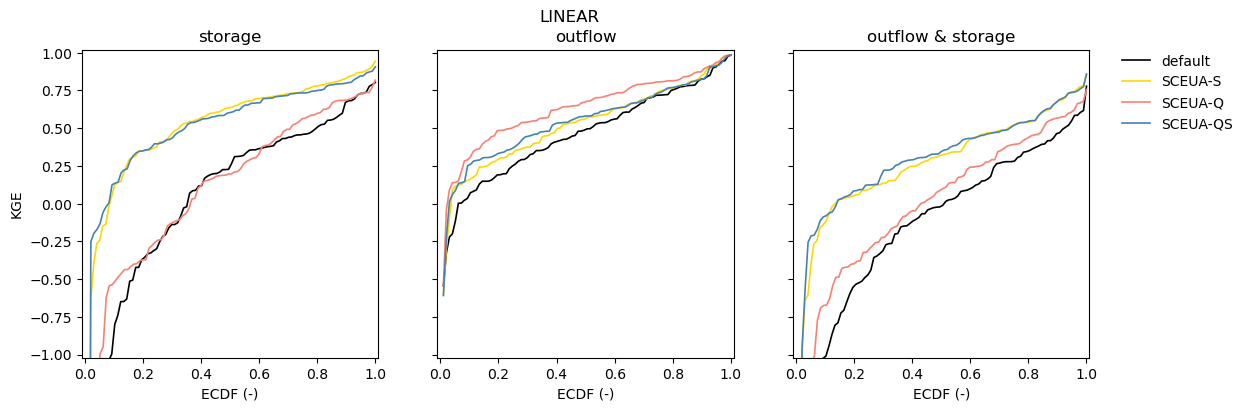

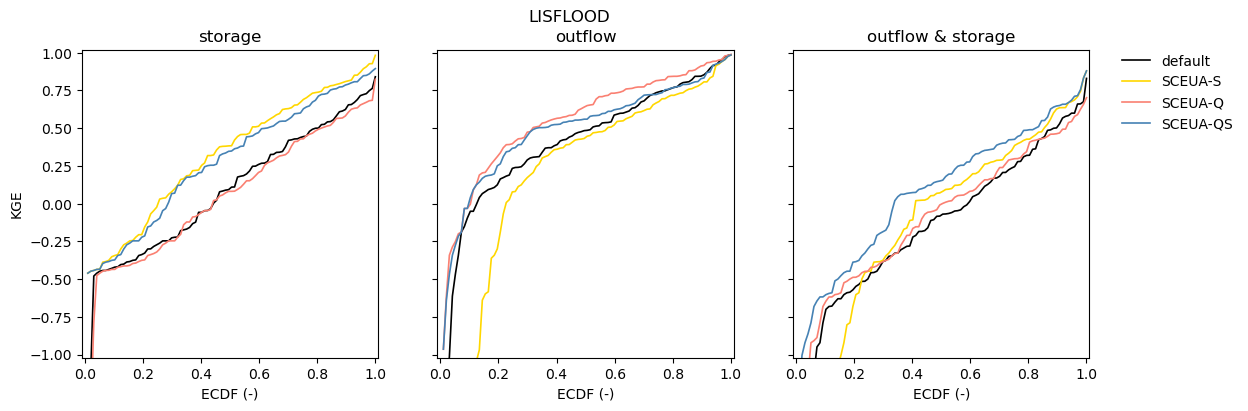

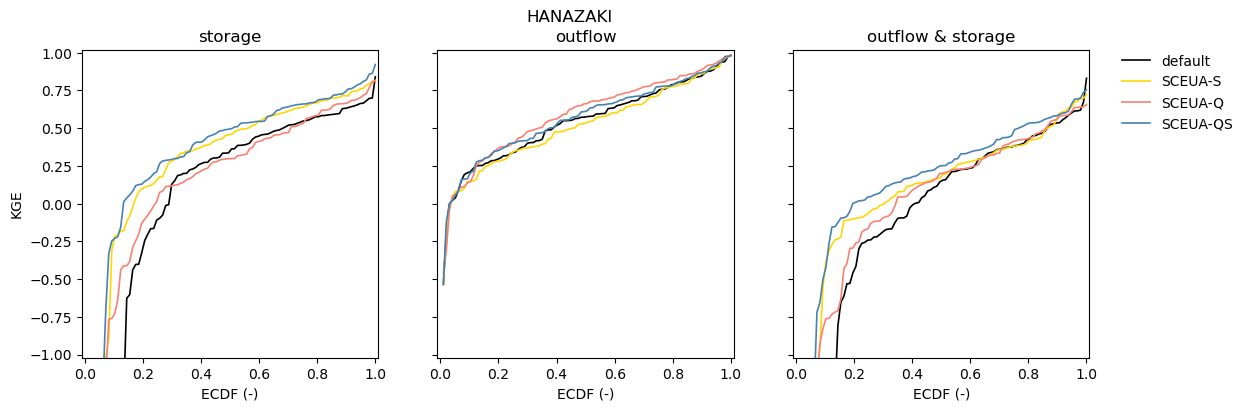

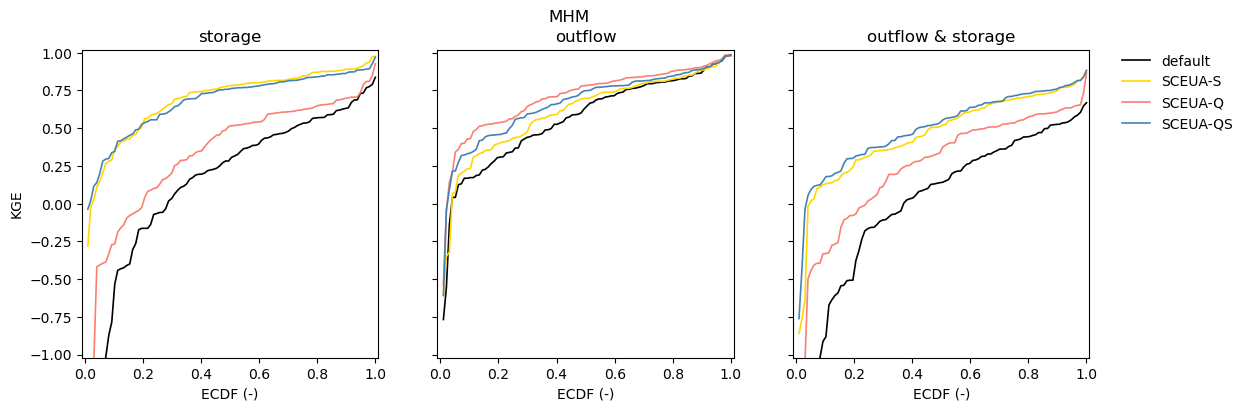

In [19]:
run_color = {
    'default': 'k',
    'SCEUA-Q': 'salmon',
    'SCEUA-S': 'gold',#'khaki',
    'SCEUA-QS': 'steelblue'
}

metric = 'KGE'

for model in performance.model.data:
    
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

    perf = performance.sel(model=model, metric=metric)

    for ax, var in zip(axes, ['storage', 'outflow']):
        da = perf[var]
        for run in da.run.data:
            ecdf = ECDF(da.sel(run=run).to_pandas(), plot=False)
            ax.plot(ecdf.index, ecdf.values, c=run_color[run], lw=1.2, label=run)
        ax.set(#xlim=(-1.02, 1.02),
               #ylim=(-.01, 1.01),
               xlabel='ECDF (-)',
               title=var)
        if ax == axes[0]:
            ax.set_ylabel(metric)

    ax = axes[2]
    KGE_bivar = 1 - ((1 - perf['storage'])**2 + (1 - perf['outflow'])**2)**.5
    for run in KGE_bivar.run.data:
        ecdf = ECDF(KGE_bivar.sel(run=run).to_pandas(), plot=False)
        ax.plot(ecdf.index, ecdf.values, c=run_color[run], lw=1.2, label=run)
    ax.set(ylim=(-1.02, 1.02),
           xlim=(-.01, 1.01),
           xlabel='ECDF (-)',
           title='outflow & storage')

    fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);
    fig.suptitle(model.upper());

    plt.savefig(PATH_RESULTS / model / f'ecdf_KGE.jpg', dpi=300, bbox_inches='tight');

#### Compare models

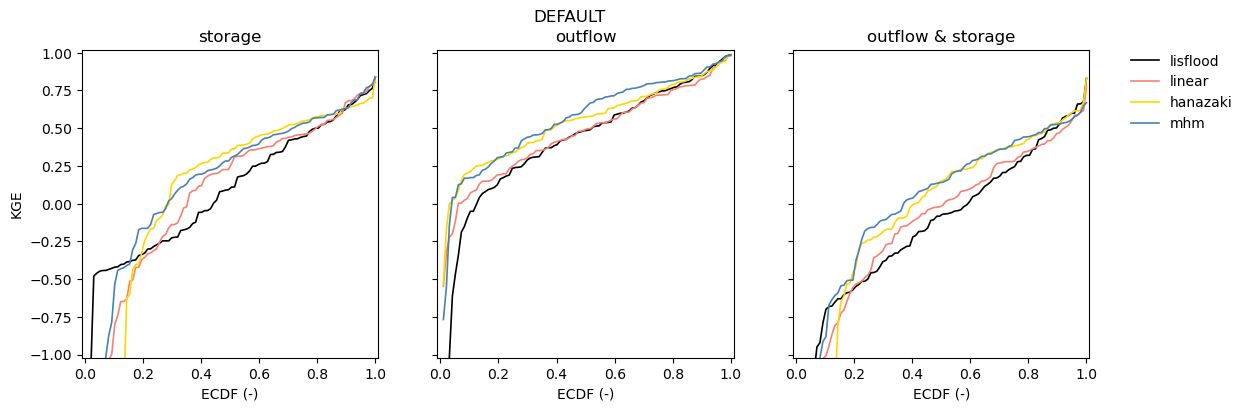

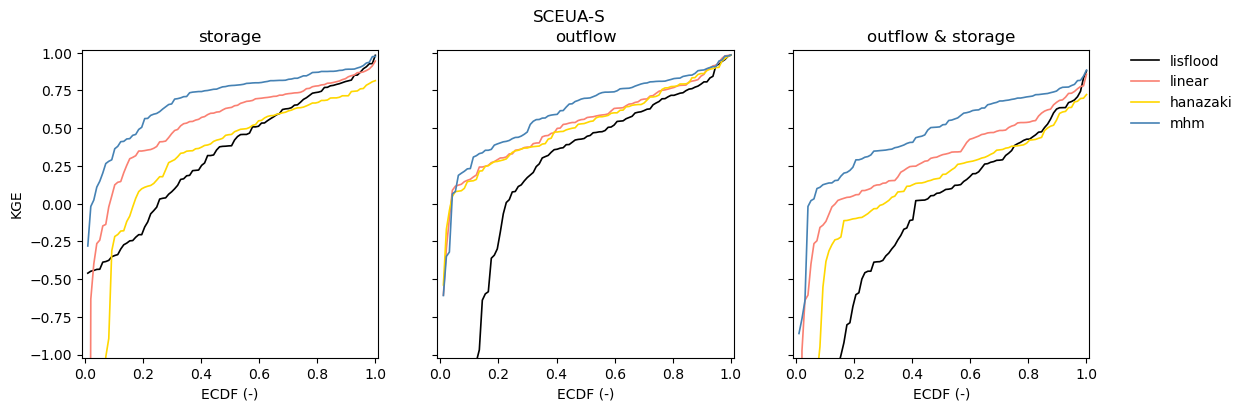

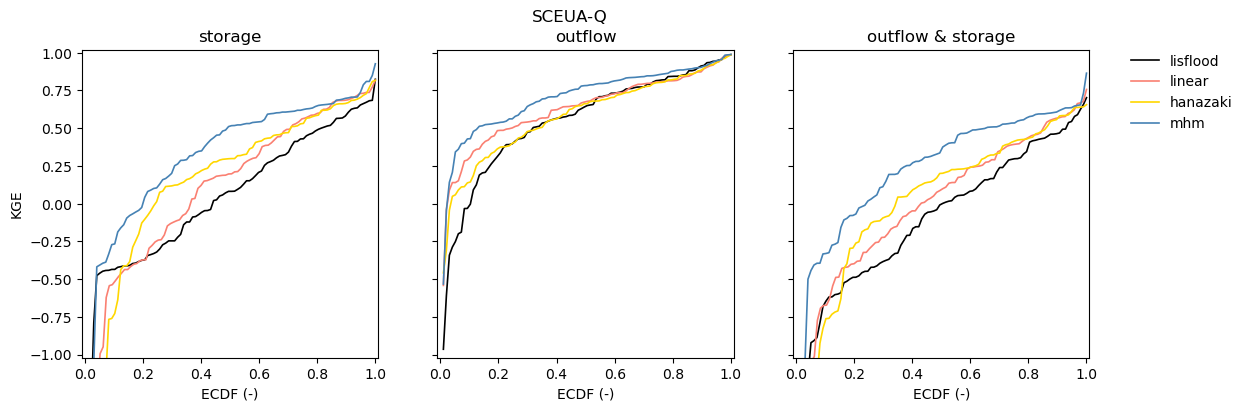

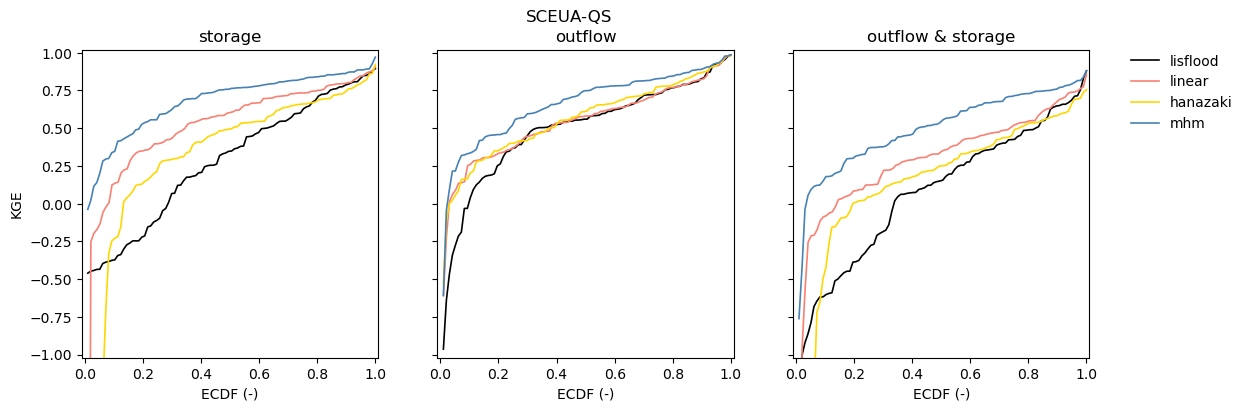

In [20]:
model_color = {
    'lisflood': 'k',
    'linear': 'salmon',
    'hanazaki': 'gold',#'khaki',
    'mhm': 'steelblue'
}

metric = 'KGE'

for run in performance.run.data:
    
    fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)

    perf = performance.sel(run=run, metric=metric)

    for ax, var in zip(axes, ['storage', 'outflow']):
        da = perf[var]
        for model, c in model_color.items():
            ecdf = ECDF(da.sel(model=model).to_pandas(), plot=False)
            ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=model)
        ax.set(xlabel='ECDF (-)',
               title=var)
        if ax == axes[0]:
            ax.set_ylabel(metric)

    ax = axes[2]
    KGE_bivar = 1 - ((1 - perf['storage'])**2 + (1 - perf['outflow'])**2)**.5
    for model, c in model_color.items():
        ecdf = ECDF(KGE_bivar.sel(model=model).to_pandas(), plot=False)
        ax.plot(ecdf.index, ecdf.values, c=c, lw=1.2, label=model)
    ax.set(ylim=(-1.02, 1.02),
           xlim=(-.01, 1.01),
           xlabel='ECDF (-)',
           title='outflow & storage')

    fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);
    fig.suptitle(run.upper());

    plt.savefig(PATH_RESULTS / f'ecdf_KGE_{run}.jpg', dpi=300, bbox_inches='tight');

## Correct parameter files

```Python
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.utils.timeseries import create_demand
from lisfloodreservoirs.models import get_model
import copy

for routine in ['mhm']:
    for run in ['SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']:
        # path results
        path = PATH_RESULTS / routine / runs[run]

        for file in path.glob('*samples.csv'):
                    
            # reservoir ID and time series
            grand_id = int(file.stem.split('_')[0])
            ts = timeseries[grand_id]

            # storage attributes (m3)
            Vtot = ts.storage.max()
            Vmin = max(0, ts.storage.min())
            # flow attributes (m3/s)
            Qmin = max(0, ts.outflow.min())
            # model-independent reservoir attributes
            reservoir_attrs = {
                'Vmin': Vmin,
                'Vtot': Vtot,
                'Qmin': Qmin,
                }
            if routine == 'hanazaki':
                # catchment area (m2)
                A = int(attributes.loc[grand_id, 'CATCH_SKM'] * 1e6)
                reservoir_attrs.update({'A': A})
                del reservoir_attrs['Qmin']
            elif routine == 'mhm':
                # create a demand time series
                bias = ts.outflow.mean() / ts.inflow.mean()
                demand = create_demand(ts.outflow,
                                       water_stress=min(1, bias),
                                       window=28)

            # read calibration results
            iterations, parameters = read_results(file)

            # udpate reservoir attributes
            calibrated_attrs = copy.deepcopy(reservoir_attrs)
            if routine == 'hanazaki':
                Vf = float(ts.storage.quantile(parameters['alpha']))
                Ve = Vtot - parameters['beta'] * (Vtot - Vf)
                Vmin = parameters['gamma'] * Vf
                Qn = parameters['delta'] * ts.inflow.mean()
                Qf = parameters['epsilon'] * return_period(ts.inflow, T=100)
                calibrated_attrs.update({
                    'Vf': Vf,
                    'Ve': Ve,
                    'Vmin': Vmin,
                    'Qn': Qn,
                    'Qf': Qf,
                    'A': A
                })
            elif routine == 'mhm':
                calibrated_attrs.update(parameters)
                calibrated_attrs.update({
                    'avg_inflow': ts.inflow.mean(),
                    'avg_demand': demand.mean()
                })

            # declare reservoir
            res = get_model(routine, **calibrated_attrs)
            
            # export calibrated parameters
            with open(path / f'{grand_id}_optimal_parameters.yml', 'w') as f:
                yaml.dump(res.get_params(), f)
```